In [1]:
require(data.table)
require(cowplot)
require(ggplot2)
require(scattermore)
require(pbapply)
pboptions(type="timer")

Loading required package: data.table

Loading required package: cowplot

Warning message:
“replacing previous import ‘vctrs::data_frame’ by ‘tibble::data_frame’ when loading ‘dplyr’”

********************************************************

Note: As of version 1.0.0, cowplot does not change the

  default ggplot2 theme anymore. To recover the previous

  behavior, execute:
  theme_set(theme_cowplot())

********************************************************


Loading required package: ggplot2

Loading required package: scattermore

Loading required package: pbapply



In [2]:
root_path = "/mnt/data/Imaging/202105-Deconwolf/data_210726"

In [3]:
dots_data = readRDS(file.path(root_path, "dots_data.rds"))

In [4]:
dots_data2 = dots_data[is.finite(SNR2) & SNR2 > 0 & Value2 > 0]

# Find tentative intensity threshold for 20x datasets

### After filtering for FWHM in [0.5; 5] and selecting only dots in (selected) nuclei

In [5]:
nuclear_features = fread("../../data/selected_nuclei.tsv", key=c("sid", "nid"))

In [6]:
ddata = dots_data2[FWHM >= .5 & FWHM <= 5 & nid > 0]
setkeyv(ddata, c("series_id", "nid"))
ddata2 = nuclear_features[ddata][!is.na(size)]

In [7]:
ddata3 = ddata2["20x" == magnification]

### Checking intensity and SNR density and scatter plots

  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=07s  


Warning message:
“Transformation introduced infinite values in continuous y-axis”


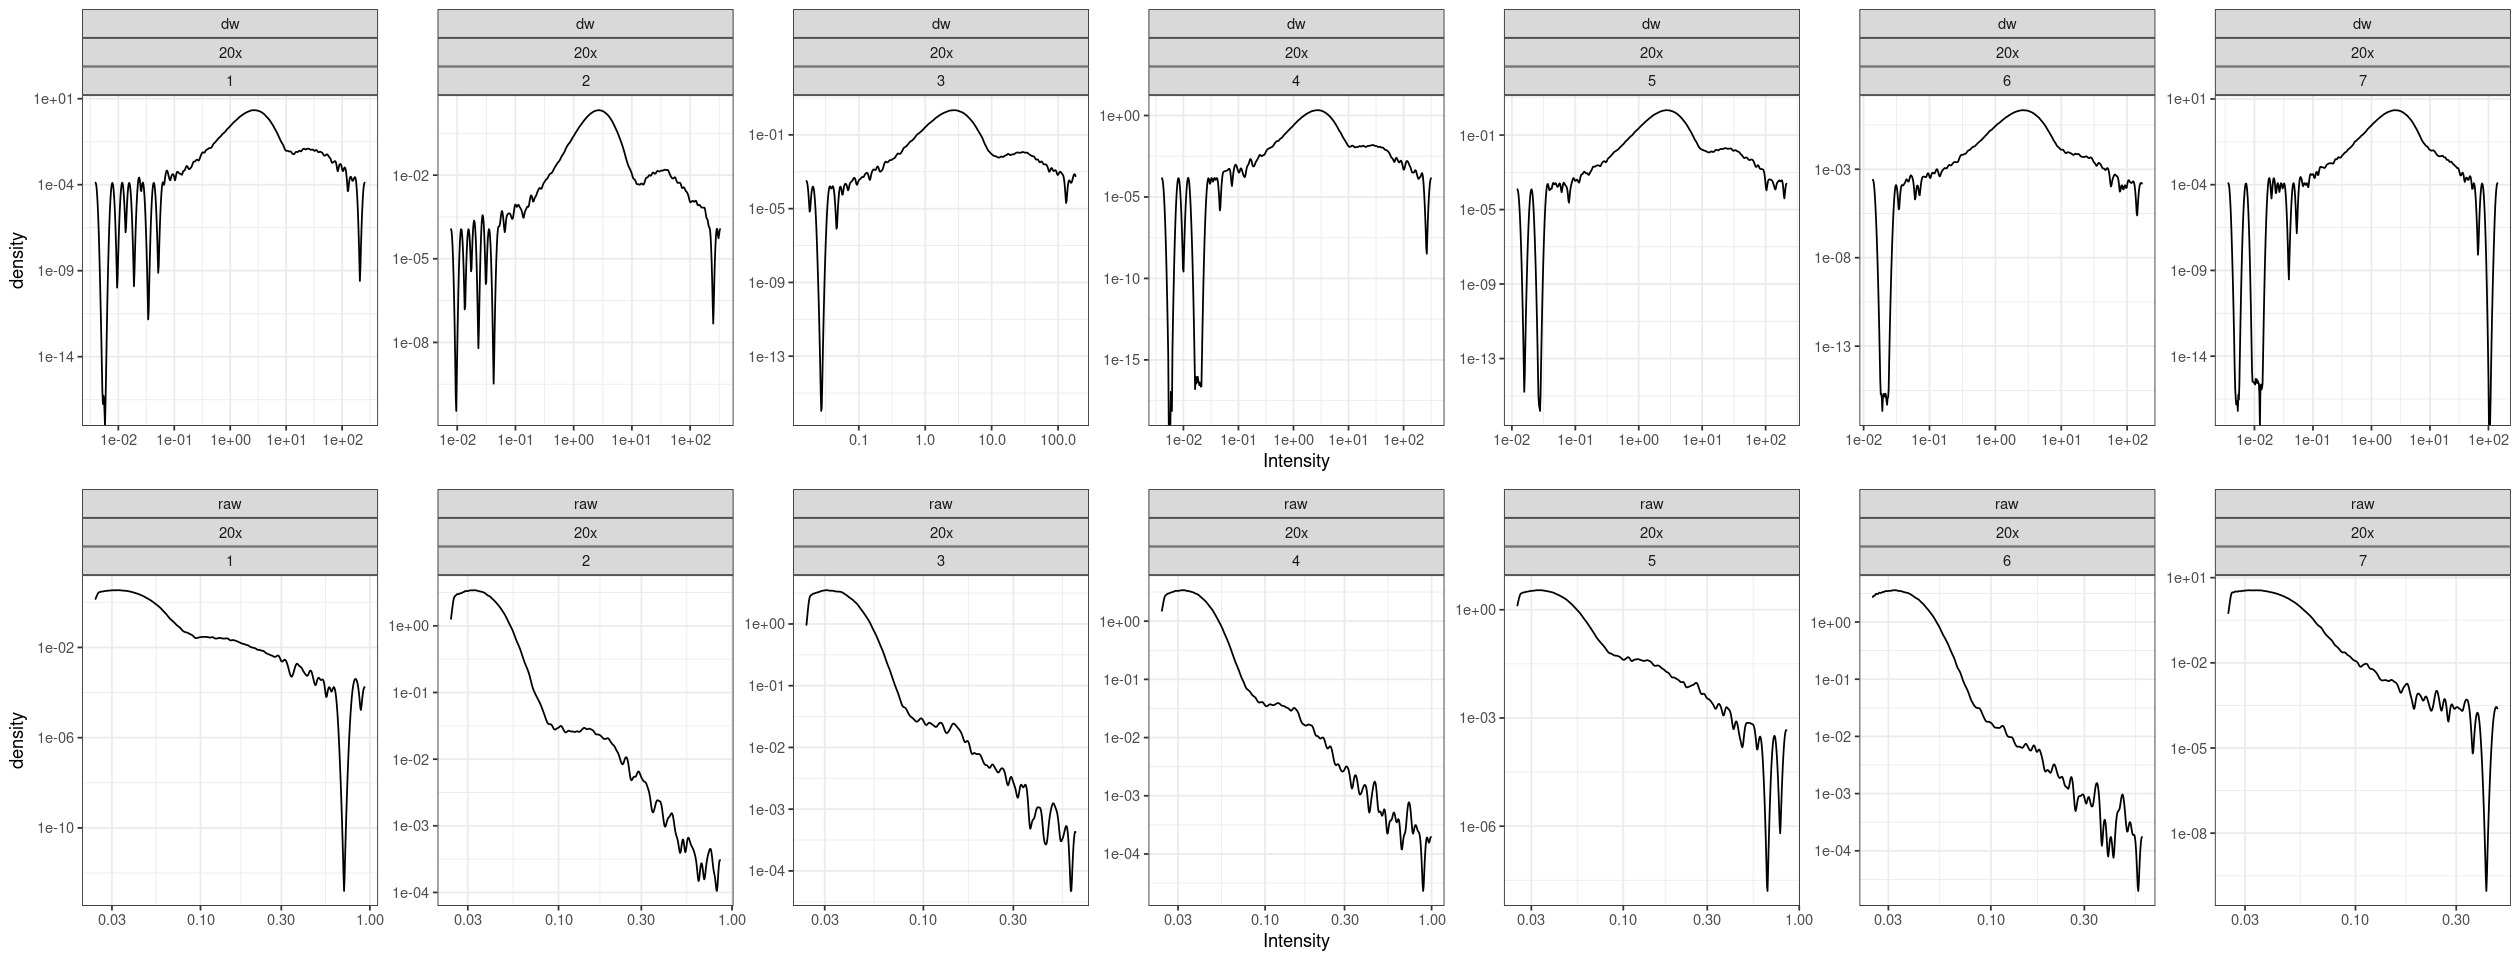

In [8]:
plist_density = pblapply(split(ddata3, list(ddata3$magnification, ddata3$image_type)),
    function(pdata) {
        p1 = ggplot(pdata, aes(x=Value2)) + geom_density() +
            facet_wrap(~image_type~magnification~sid, nrow=1, scales="free") + theme_bw() +
            scale_x_log10() + scale_y_log10() + labs(x="Intensity")
    }, cl=4
)
options(repr.plot.width=21, repr.plot.height=8)
plot_grid(plotlist=plist_density, nrow=2)

  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=05s  


Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”


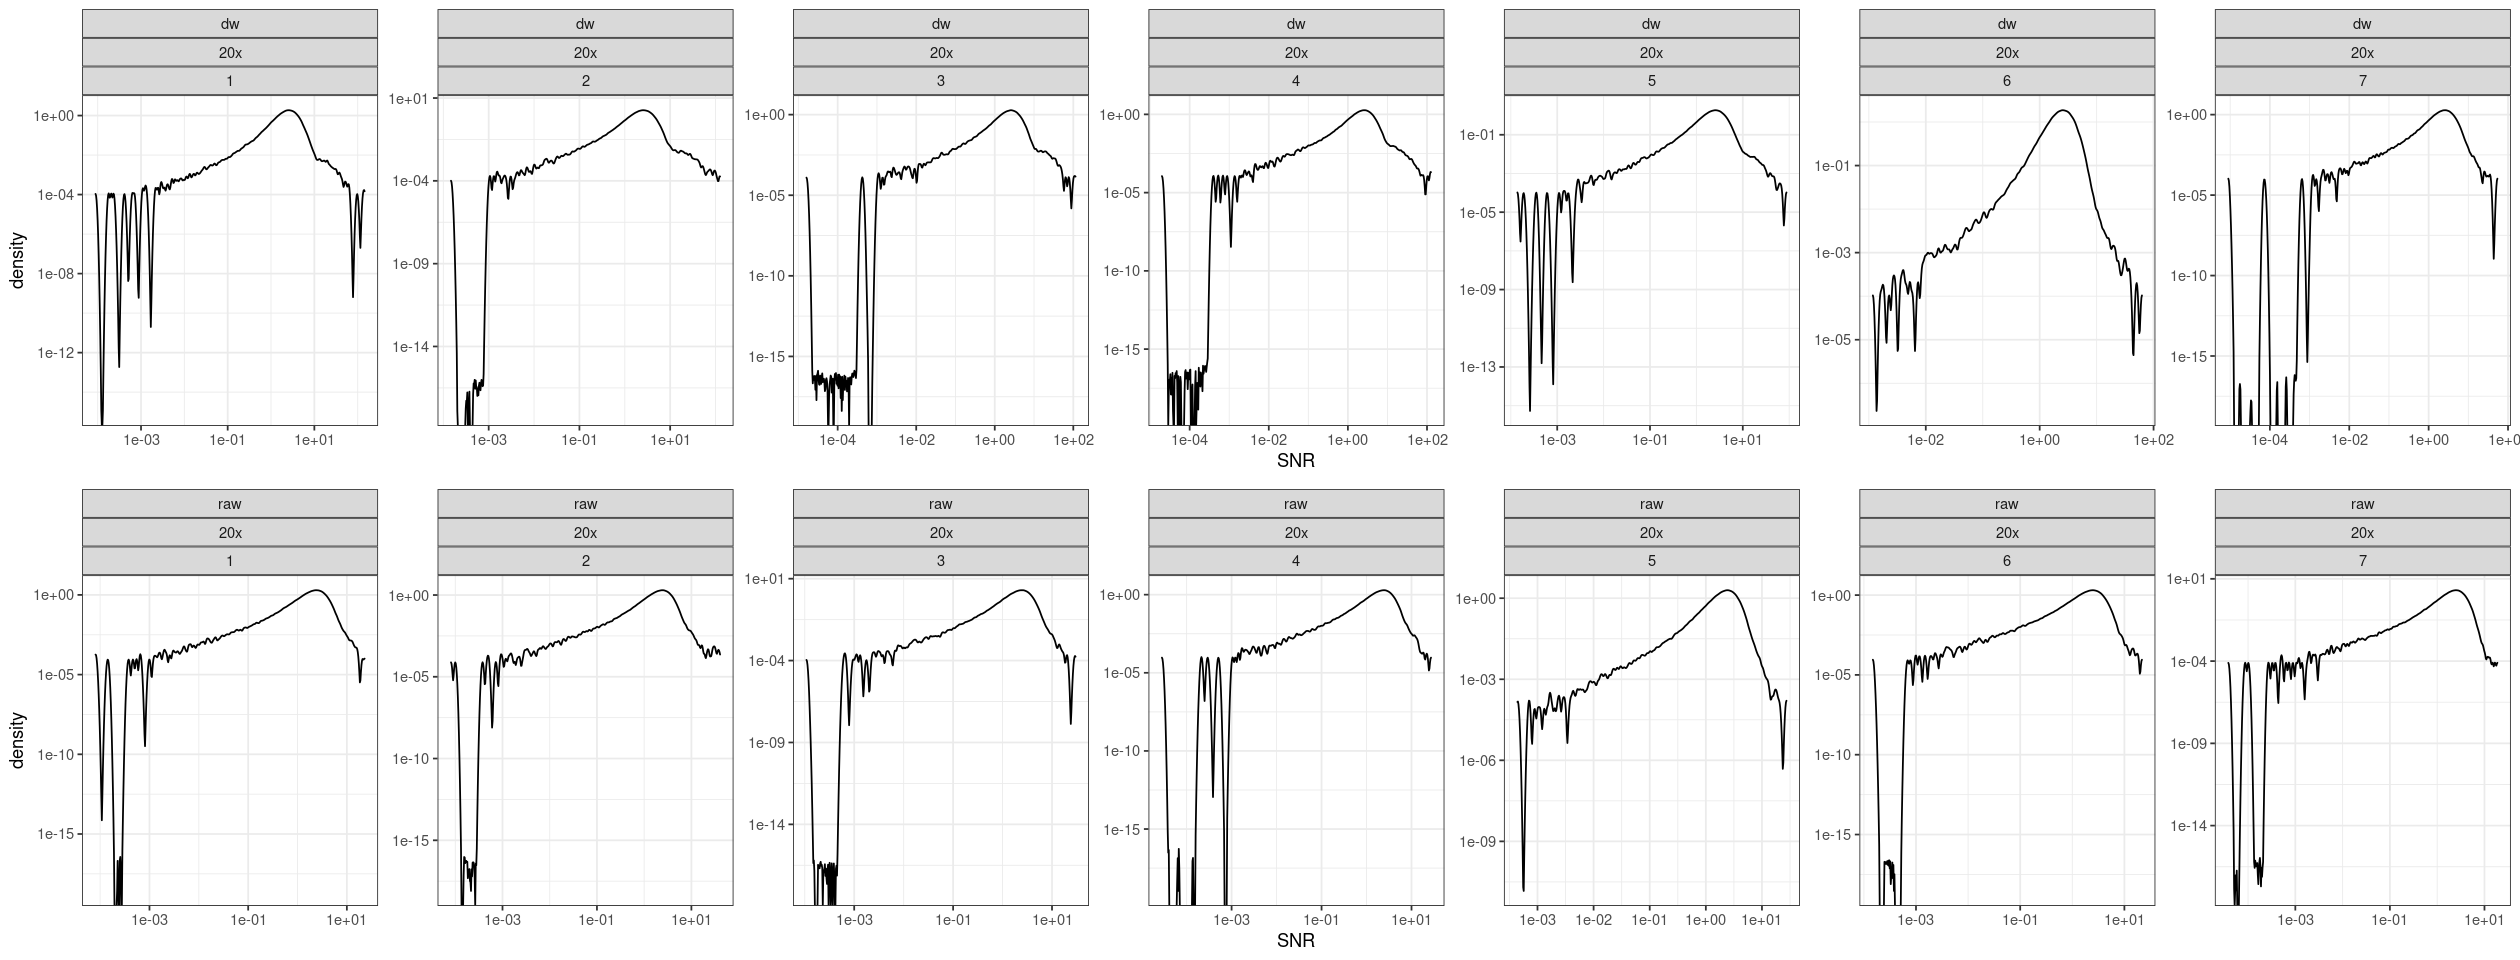

In [9]:
plist_density = pblapply(split(ddata3, list(ddata3$magnification, ddata3$image_type)),
    function(pdata) {
        p1 = ggplot(pdata, aes(x=SNR2)) + geom_density() +
            facet_wrap(~image_type~magnification~sid, nrow=1, scales="free") + theme_bw() +
            scale_x_log10() + scale_y_log10() + labs(x="SNR")
    }, cl=4
)
options(repr.plot.width=21, repr.plot.height=8)
plot_grid(plotlist=plist_density, nrow=2)

  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=06s  


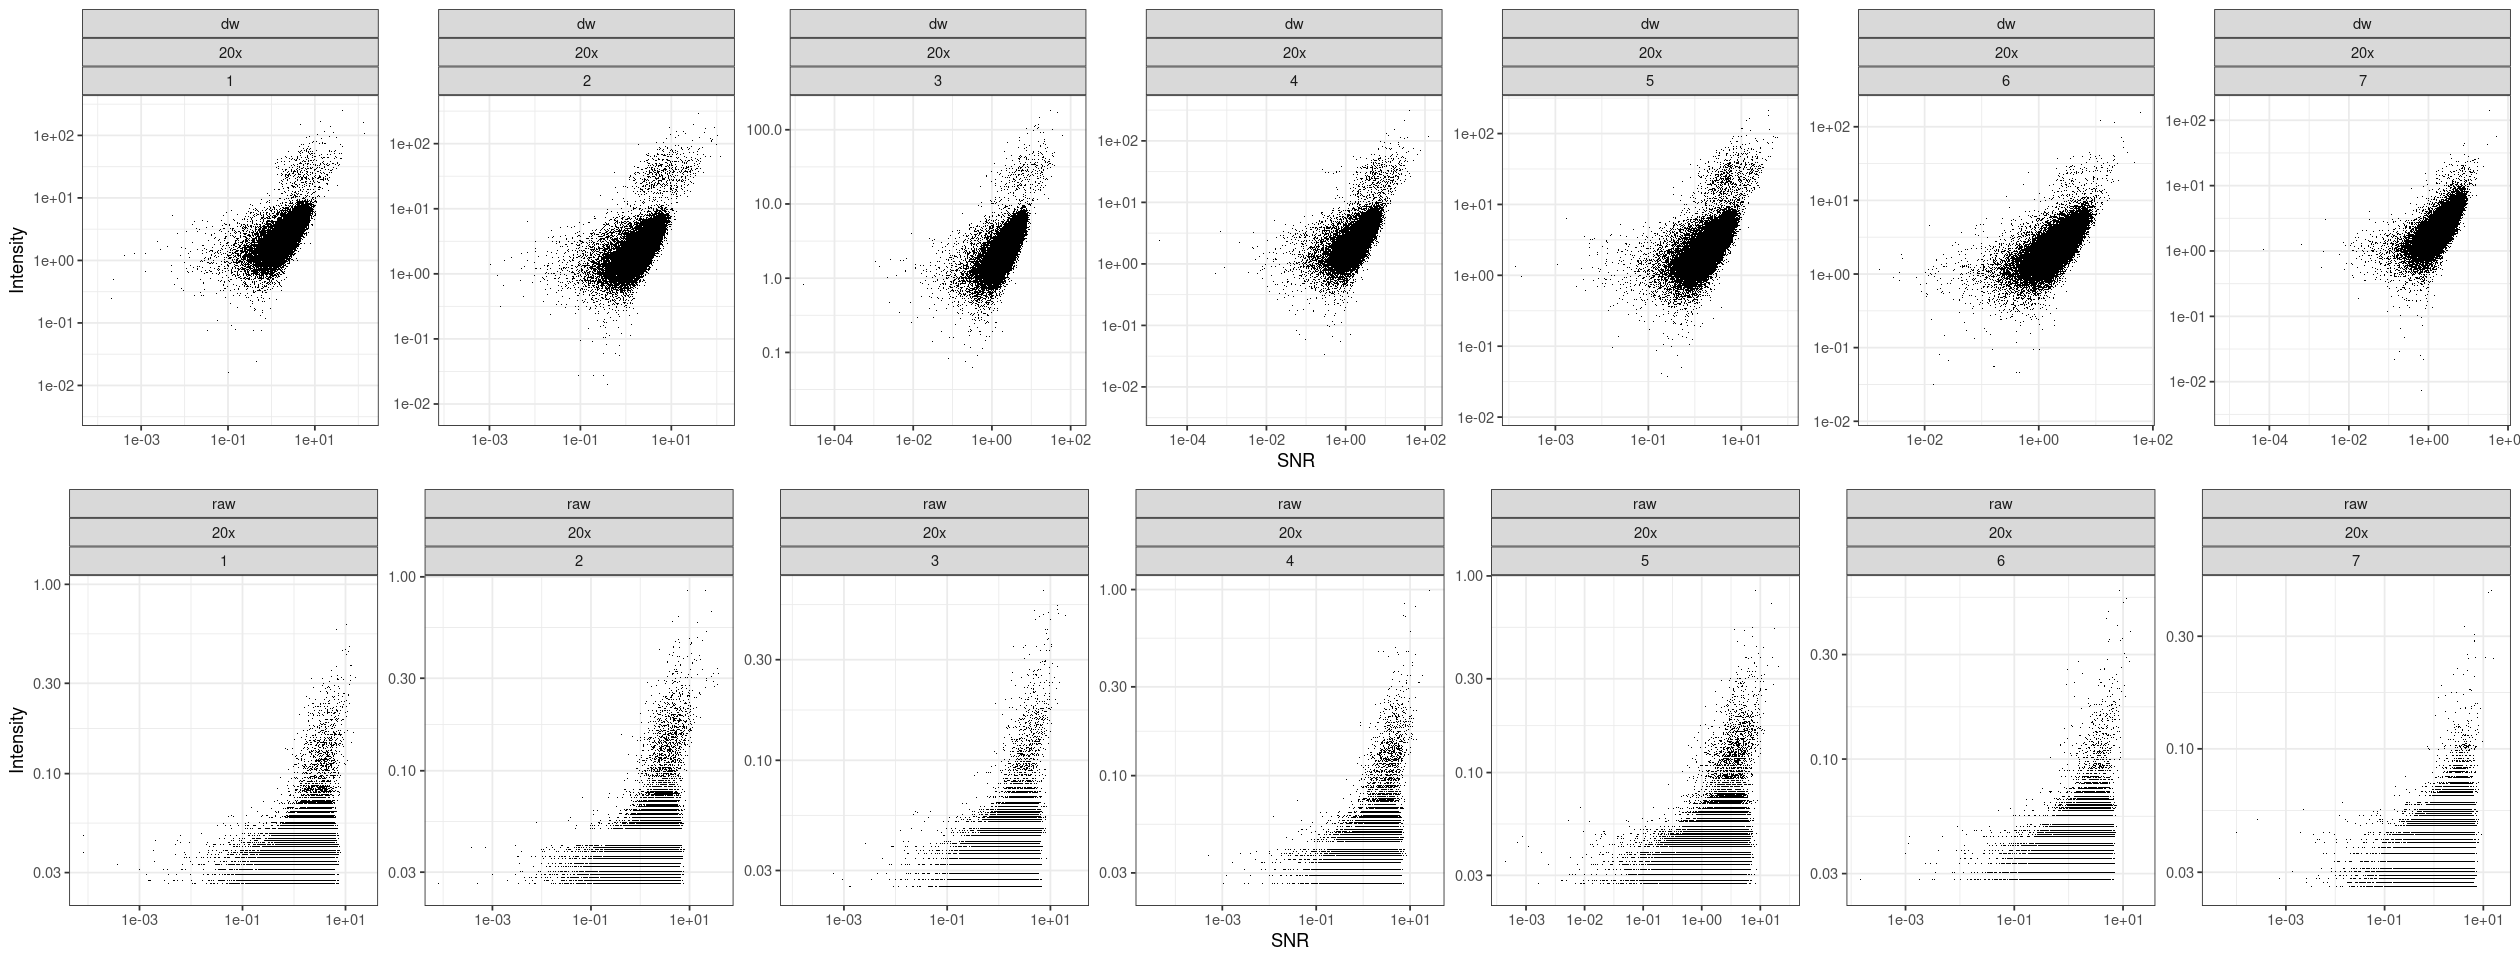

In [10]:
plist = pblapply(split(ddata3, list(ddata3$magnification, ddata3$image_type)),
    function(pdata) {
        p1 = ggplot(pdata, aes(x=SNR2, y=Value2)) + geom_scattermore() +
            facet_wrap(~image_type~magnification~sid, nrow=1, scales="free") + theme_bw() +
            scale_x_log10() + scale_y_log10() + labs(x="SNR", y="Intensity")
    }, cl=4
)
options(repr.plot.width=21, repr.plot.height=8)
plot_grid(plotlist=plist, nrow=2)

### Field-based thresholds

In [11]:
thr_table = rbindlist(list(
    data.table(
        image_type="dw",
        magnification="20x",
        sid=1:7,
        thr=c(11, 12, 11, 11, 10.5, 11, 12)
    ),
    data.table(
        image_type="raw",
        magnification="20x",
        sid=1:7,
        thr=c(.095, .095, .085, .085, .092, .092, .096)
    )
))

In [12]:
#threshold = .096
#selected_sid = 7
#pdata = ddata3["20x"==magnification&"raw"==image_type&selected_sid==sid]
#p1 = ggplot(pdata, aes(x=Value2)) + geom_density() +
#    geom_vline(xintercept=threshold, color="red") +
#    facet_wrap(~image_type~magnification~sid, nrow=1, scales="free") + theme_bw() +
#    scale_x_log10() + scale_y_log10() + labs(x="Intensity")
#p2 = ggplot(pdata, aes(x=SNR2, y=Value2)) + geom_scattermore() +
#    geom_hline(yintercept=threshold, color="red") +
#    facet_wrap(~image_type~magnification~sid, nrow=1, scales="free") + theme_bw() +
#    scale_x_log10() + scale_y_log10() + labs(x="SNR", y="Intensity")
#options(repr.plot.width=12, repr.plot.height=6)
#plot_grid(p1, p2, nrow=1)

  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=06s  


Warning message:
“Transformation introduced infinite values in continuous y-axis”


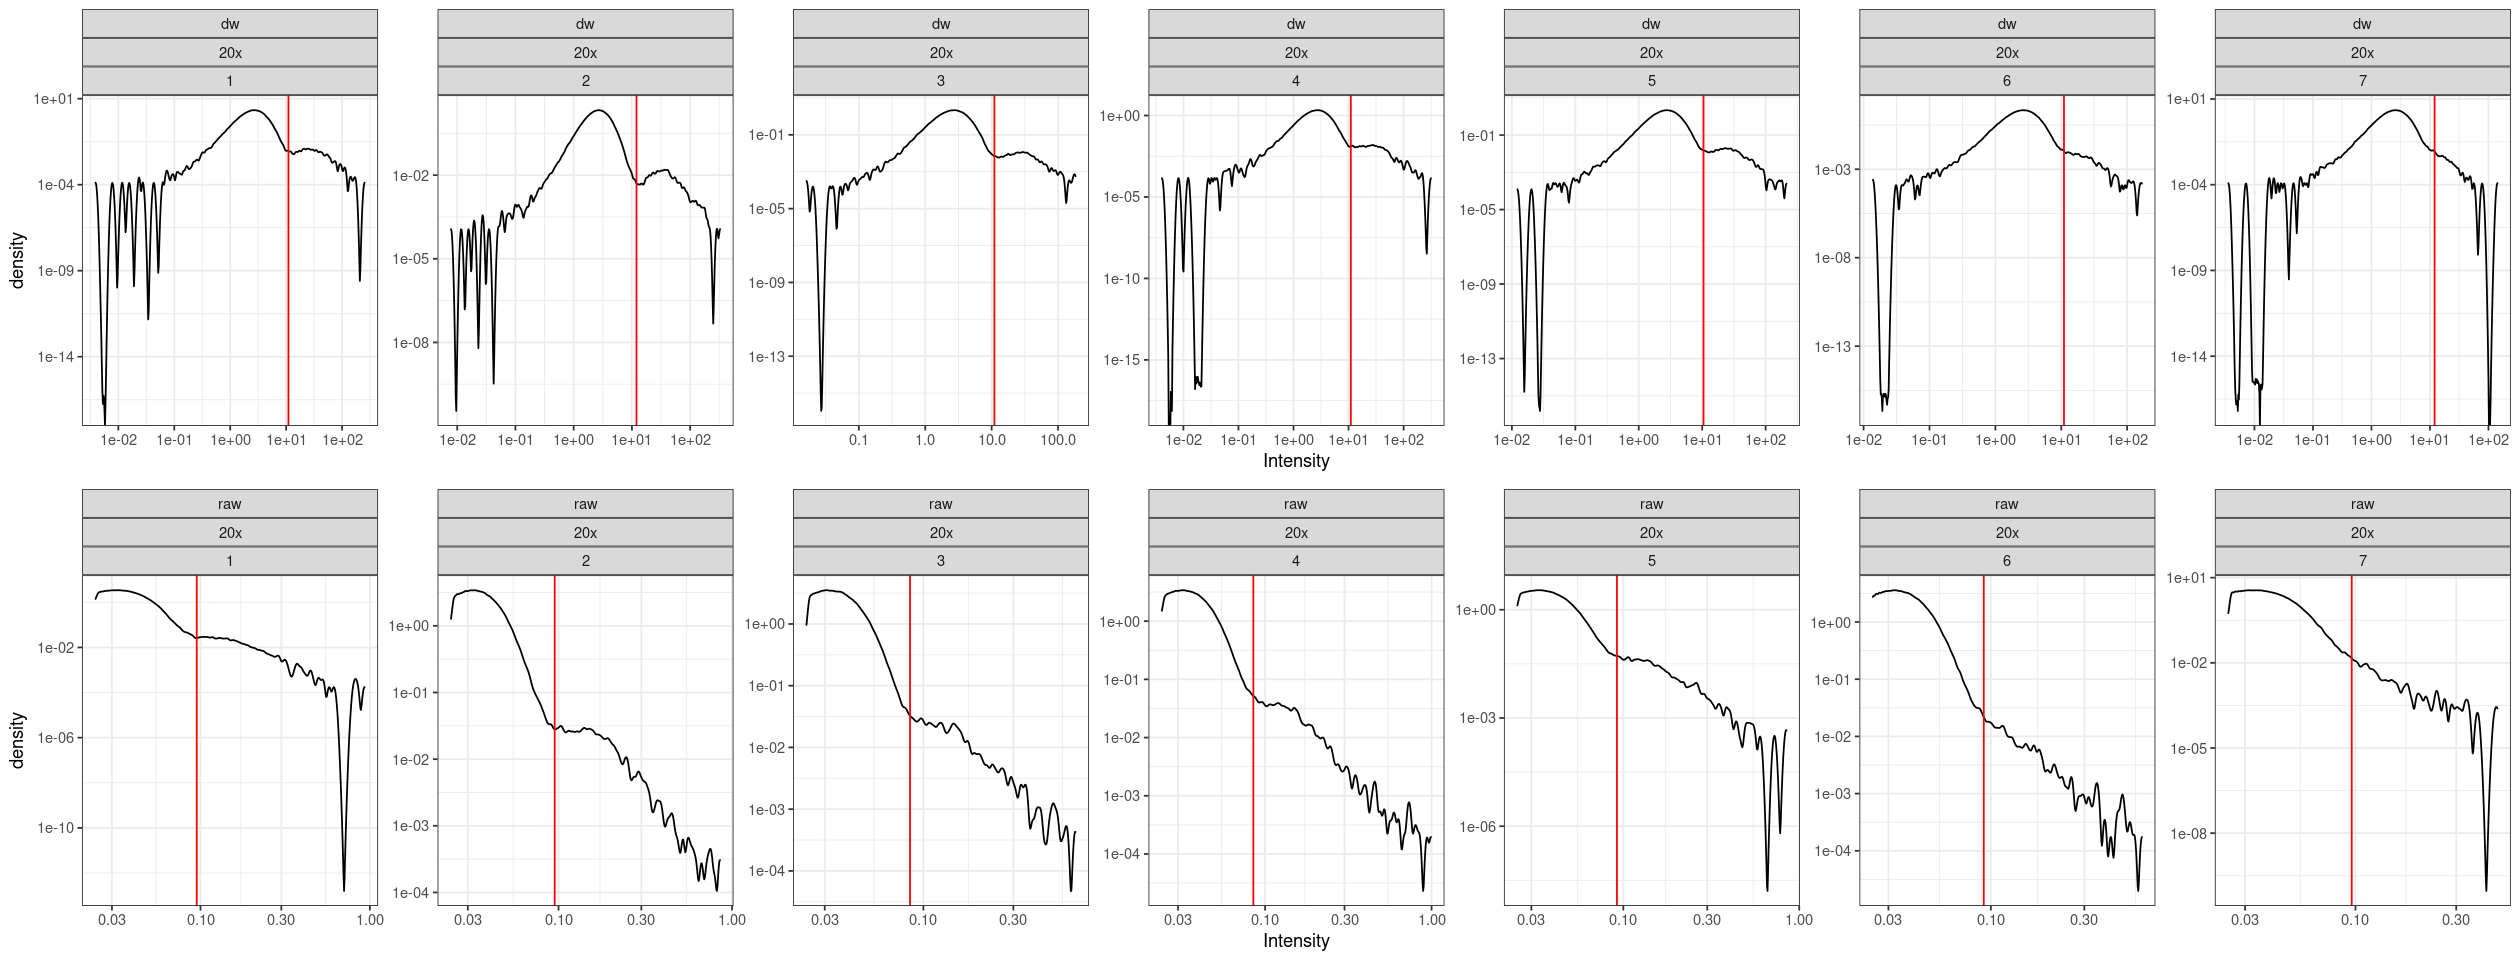

In [13]:
plist_density = pblapply(split(ddata3, list(ddata3$magnification, ddata3$image_type)),
    function(pdata) {
        selected_magnification = pdata[1, magnification]
        selected_image_type = pdata[1, image_type]
        selected_thresholds = thr_table[magnification == selected_magnification & image_type == selected_image_type,]
        p1 = ggplot(pdata, aes(x=Value2)) + geom_density() +
            geom_vline(data=selected_thresholds, aes(xintercept=thr), color="red") +
            facet_wrap(~image_type~magnification~sid, nrow=1, scales="free") + theme_bw() +
            scale_x_log10() + scale_y_log10() + labs(x="Intensity")
    }, cl=4
)
options(repr.plot.width=21, repr.plot.height=8)
plot_grid(plotlist=plist_density, nrow=2)

  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=07s  


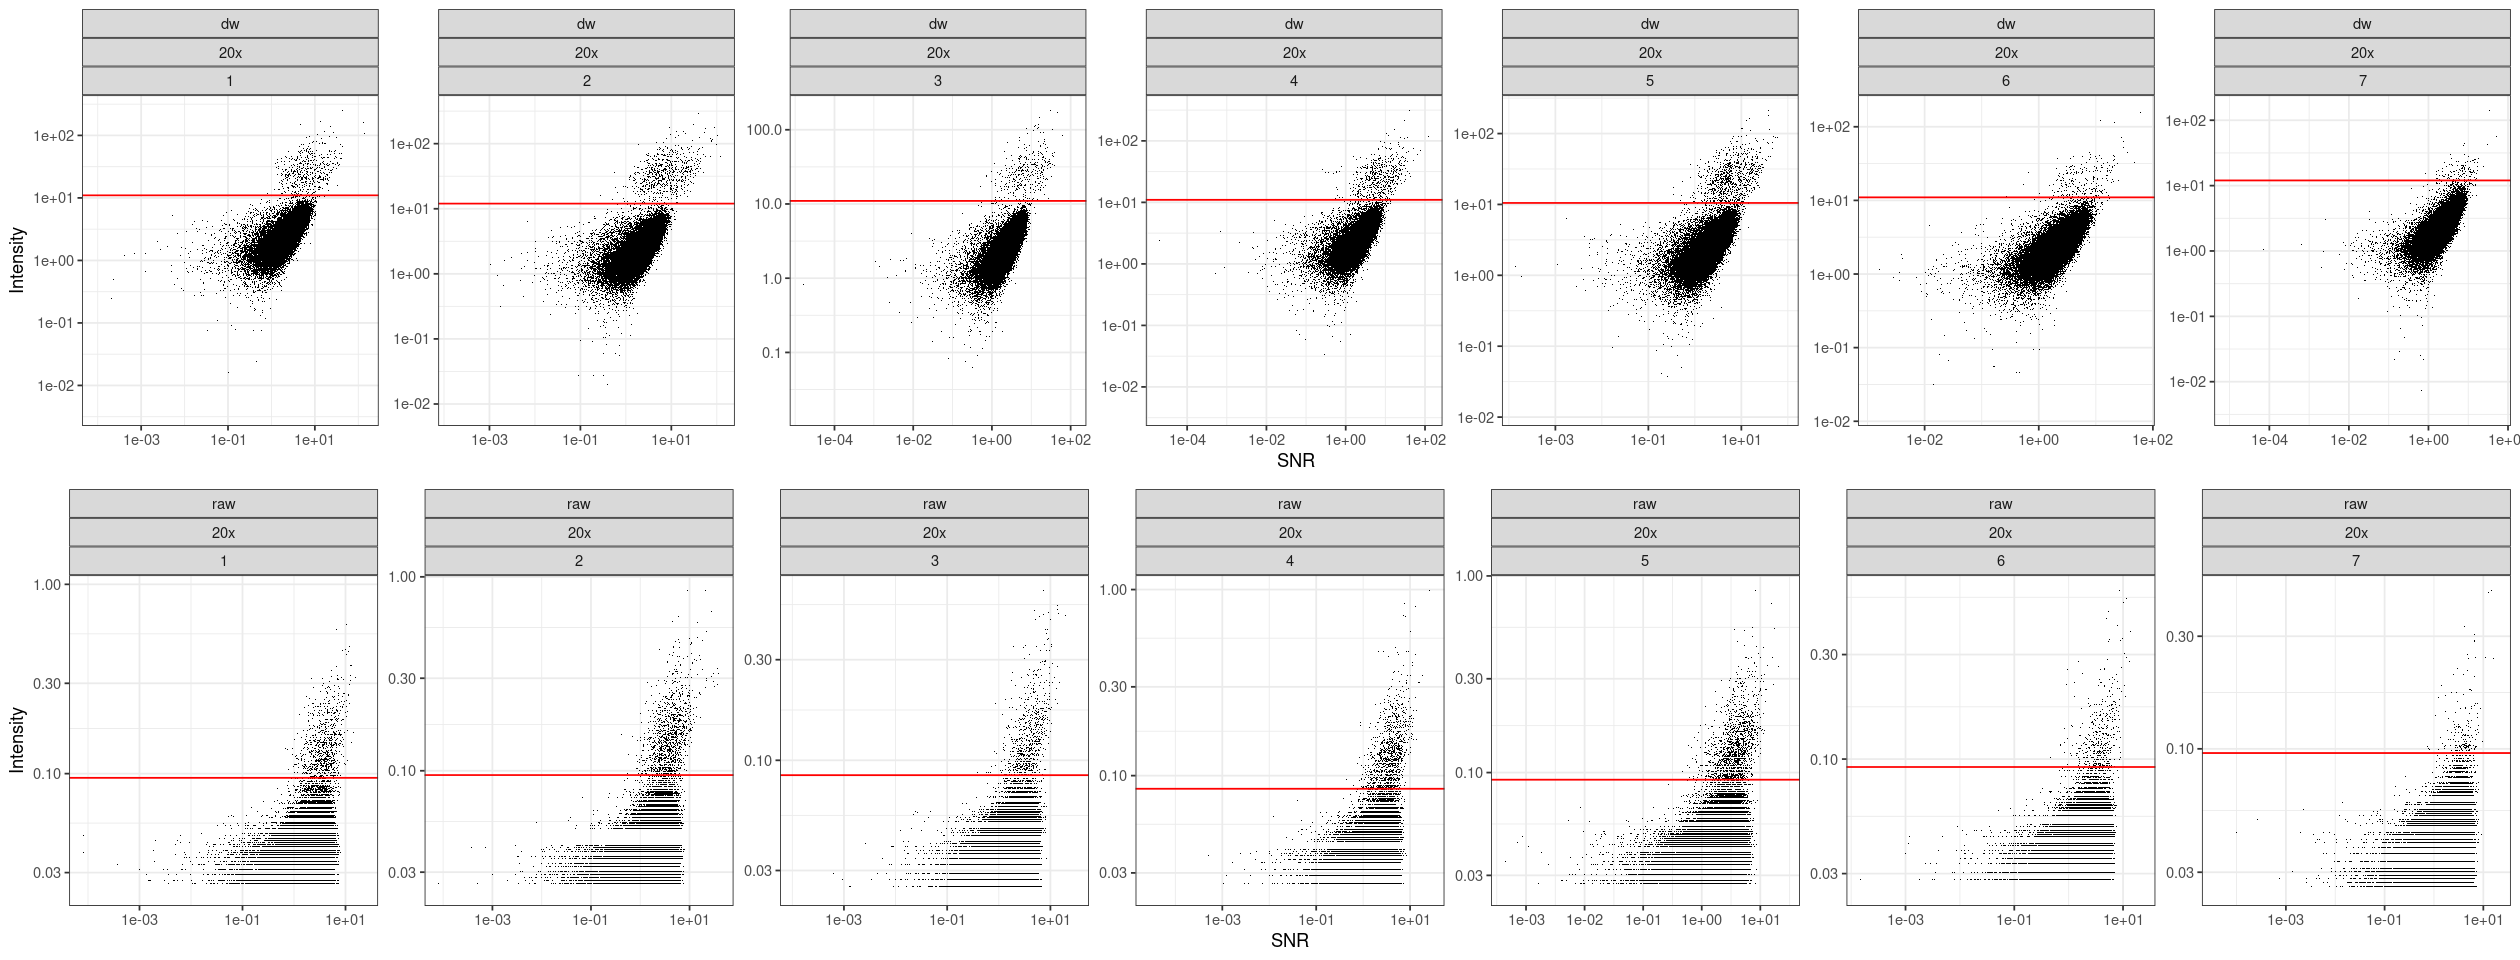

In [14]:
plist = pblapply(split(ddata3, list(ddata3$magnification, ddata3$image_type)),
    function(pdata) {
        selected_magnification = pdata[1, magnification]
        selected_image_type = pdata[1, image_type]
        selected_thresholds = thr_table[magnification == selected_magnification & image_type == selected_image_type,]
        p1 = ggplot(pdata, aes(x=SNR2, y=Value2)) + geom_scattermore() +
            geom_hline(data=selected_thresholds, aes(yintercept=thr), color="red") +
            facet_wrap(~image_type~magnification~sid, nrow=1, scales="free") + theme_bw() +
            scale_x_log10() + scale_y_log10() + labs(x="SNR", y="Intensity")
    }, cl=4
)
options(repr.plot.width=21, repr.plot.height=8)
plot_grid(plotlist=plist, nrow=2)

In [15]:
fwrite(thr_table, "../../data/magnifications_matching/intensity_thresholds.by_field.tsv", sep="\t")